### Импорты

При первом запуске в командную строку:

python -m spacy download ru_core_news_sm

python -m spacy download en_core_web_sm

In [2]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    average_precision_score
)
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE
import spacy
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from prettytable import PrettyTable
from tabulate import tabulate


Языковые пакеты

In [3]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

nlp_ru = spacy.load("ru_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Krasa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Krasa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Krasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_pickle('text_train.pkl')

In [36]:
df.head()

,transcript_parts,category_parts,sub_category_parts,theme_parts,matrix_name,matrix_language,cheating_percent,cheating,answer_length,answer_length_tokens,...,avg_stop_words,total_stop_words,total_lexical_diversity,avg_lexical_diversity,stop_word_percentage,mean_stop_word_percentage,max_stop_word_percentage,min_stop_word_percentage,answers_without_stop_words,total_words
1206,[interviewer: Что такое Apache Spark и какие е...,[Hadoop],[Spark],"[Spark Core, Spark SQL, Spark Streaming]",DE+Hadoop,ru,0.0,0,"[[1234, 1292, 1788]]","[[451, 241, 670]]",...,73.00,219,0.560,0.568,"[21.29, 49.53, 33.47]",34.763333,49.53,21.29,0,609
2133,[interviewer: Explain the concept of an algori...,[Java],[ALGORITHMS AND DATA STRUCTURES],[Algorithms],Java,en,0.0,0,"[[776, 473, 817]]","[[145, 99, 177]]",...,58.00,174,0.520,0.538,"[46.72, 48.78, 52.03]",49.176667,52.03,46.72,0,352
1778,[interviewer: Что такое Apache Kafka и для чег...,"[Apache Kafka / Apache Airflow, Apache Kafka /...","[Введение в Apache Kafka, Введение в Apache Ka...","[Архитектура Apache Kafka и её компоненты, Осн...",DE+Hadoop,ru,0.0,0,"[[0, 4, 0], [0, 0, 0]]","[[0, 2, 0], [0, 0, 0]]",...,0.00,0,1.000,0.167,"[0, 0.0, 0, 0, 0, 0]",0.000000,0.00,0.00,6,1
240,[interviewer: Что такое пользовательская истор...,"[Технические знания по BA, QA, Design, Техниче...","[BA, BA, BA, BA, BA, BA, BA, QA, QA, QA, QA, Q...","[Работа с требованиями, Критерии подготовленно...",PM,ru,0.0,0,"[[440, 580, 570], [467, 555, 419], [1442, 707,...","[[167, 233, 224], [186, 246, 170], [573, 298, ...",...,42.25,2028,0.599,0.649,"[36.36, 36.36, 39.77, 32.81, 48.1, 26.98, 22.4...",35.843958,56.36,0.00,2,5497
1063,[interviewer: Что такое SDLC?\ntrainee: Модель...,"[DevOps, DevOps, DevOps, DevOps, DevOps]","[Основы разработки ПО, Основы разработки ПО, О...","[Основные понятия, Git, Языки программирования...",DevOps,ru,0.0,0,"[[114, 296, 243], [393, 163, 107], [421, 196, ...","[[47, 120, 87], [147, 57, 43], [173, 72, 259],...",...,13.47,202,0.770,0.791,"[8.33, 34.78, 30.77, 34.0, 37.04, 46.15, 35.0,...",31.165333,46.15,8.33,0,596


## Функции для очистки, лемматизации и обработки текстов

In [6]:
# Очистка текста
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # HTML-теги
    text = re.sub(r'\s+', ' ', text).strip()  # Лишние пробелы
    text = re.sub(r'[^\w\s]', '', text)  # Знаки препинания 
    return text.lower()  # Нижний регистр

# Лемматизация текста
def lemmatize_text(text):
    words = text.split()  # Разбиваем текст на слова
    lemmatized_words = []

    for word in words:
        if re.search(r'[а-яА-Я]+', word):  # Слово на русском
            doc = nlp_ru(word)
            lemmatized_word = doc[0].lemma_  # Лемматизация
        elif re.search(r'[a-zA-Z]+', word):  # Слово на английском
            doc = nlp_en(word)
            lemmatized_word = doc[0].lemma_  # Лемматизация
        else:
            lemmatized_word = word  # Если не распознано, оставить как есть
        lemmatized_words.append(lemmatized_word)
    
    return ' '.join(lemmatized_words)

# Основная функция обработки текста
def obrabotka(transcript):
    if not transcript:
        return ["", "", ""]

    # Если transcript - это список, объединяем в строку
    if isinstance(transcript, list):
        transcript = " ".join(str(item) if item is not None else "" for item in transcript)
    lines = transcript.split("\n")

    # Отфильтровываем строки, начинающиеся с trainee: или candidate:
    answers = []
    for line in lines:
        if line.lower().startswith(("trainee:", "candidate:")):
            parts = line.split(":", 1)
            if len(parts) > 1:  # Если после двоеточия есть текст
                raw_text = parts[1].strip()
                answers.append(raw_text)
            else:
                answers.append("")  # Если текста нет, добавляем пустую строку

    # Вызов очистки
    cleaned_answers = [clean_text(answer) for answer in answers]

    # Вызов лемматизации
    lemmatized_answers = [lemmatize_text(answer) for answer in cleaned_answers]

    return lemmatized_answers

#### Если работаем с прежними данными, повторно смысла запускать нет, очищенные данные уже поднимаются с text_train_with_answers.pkl ниже

In [7]:
'''
Вызов обработки, длится от 50 до 70 минут за счет обработки аномалий (3+ ответов)
Обработанные данные уже сохранены в text_train_with_answers, можете не вызывать этот блок
'''
df['only_answers'] = df['transcript_parts'].apply(obrabotka)

In [9]:
# Сохраняем весь df, включая обработанную колонку
df.to_pickle("text_train_with_answers.pkl")

#### Вместо постоянной обработки просто заменяем df с уже обработанными данными, чтобы не ждать 50+ минут

In [10]:
df = pd.read_pickle("text_train_with_answers.pkl")

#### Функция подсчета стоп слов в ответах

In [13]:
stop_words_ru = set(stopwords.words('russian'))
stop_words_en = set(stopwords.words('english'))

def count_stop_words(text):
    if not text or len(word_tokenize(text)) == 0:
        return {'russian': 0, 'english': 0} 
    
    words = word_tokenize(text)
    stop_word_count = {'russian': 0, 'english': 0}
    
    for word in words:
        word_lower = word.lower()
        if word_lower in stop_words_ru:
            stop_word_count['russian'] += 1
        elif word_lower in stop_words_en:
            stop_word_count['english'] += 1
    return stop_word_count

### Признаки

Дисперсия стоп слов между ответами

In [14]:
def calculate_stop_words(answers):
    stop_word_counts = [
        count_stop_words(answer)['russian'] + count_stop_words(answer)['english']
        for answer in answers if answer  # Пропускаем пустые строки
    ]
    return stop_word_counts

def calculate_variance(stop_word_counts):
    if len(stop_word_counts) >= 1:
        return np.var(stop_word_counts)
    return 0

df['stop_word_variance'] = df['only_answers'].apply(
    lambda answers: calculate_variance(calculate_stop_words(answers))
).round(2)


Среднее количество стоп слов

In [15]:
def calculate_avg_stop_words(answers):
    # Проверяем, что ответы есть и что это список
    if not isinstance(answers, list) or not answers:
        return 0

    # Считаем количество стоп-слов для каждого ответа
    stop_word_counts = [
        count_stop_words(answer)['russian'] + count_stop_words(answer)['english']
        for answer in answers if answer and count_stop_words(answer) is not None
    ]

    # Возвращаем среднее количество, если список не пуст, иначе 0
    return np.mean(stop_word_counts) if stop_word_counts else 0

# Применяем функцию к каждому блоку
df['avg_stop_words'] = df['only_answers'].apply(calculate_avg_stop_words).round(2)


In [98]:
def calculate_lexical_diversity(text):
    if not text:
        return 0
    words = word_tokenize(text)
    return len(set(words)) / len(words) if len(words) > 0 else 0


df['avg_lexical_diversity'] = df['only_answers'].apply(
    lambda answers: np.mean([calculate_lexical_diversity(answer) for answer in answers])
).round(3)


#### Процентное соотношение

In [19]:
# Функция для вычисления процентного соотношения стоп-слов
def calculate_stop_word_percentage(answers):
    # Проверяем, что ответы есть
    if not isinstance(answers, list) or not answers:
        return [0, 0, 0]

    # Считаем процентное соотношение для каждого ответа
    percentages = []
    for answer in answers:
        if answer:  # Пропускаем пустые ответы
            stop_word_count = sum(count_stop_words(answer).values())  # Общее количество стоп-слов
            total_words = len(word_tokenize(answer))  # Общее количество слов
            if total_words > 0:
                percentages.append(round((stop_word_count / total_words) * 100, 2))  # Процентное соотношение
            else:
                percentages.append(0)  # Если нет слов
        else:
            percentages.append(0)  # Если ответ пустой, процент 0

    # Добавляю недостающие ответы нулями, возможно позже заменю на None
    while len(percentages) < 3:
        percentages.append(0)

    return percentages

# Применяем функцию к каждому блоку
df['stop_word_percentage'] = df['only_answers'].apply(calculate_stop_word_percentage)

In [20]:
# Среднее значение
df['mean_stop_word_percentage'] = df['stop_word_percentage'].apply(lambda x: np.mean(x) if x else 0)

# Минимальное значение
df['min_stop_word_percentage'] = df['stop_word_percentage'].apply(lambda x: min(x) if x else 0)


## Метод анализа разнообразия слов

### Количество слов 

In [23]:
def calculate_total_words(answers):
    if not isinstance(answers, list) or not answers:  # Проверка на валидность данных
        return 0
    return sum(len(word_tokenize(answer)) for answer in answers if answer)  # В каждом ответе отдельно

df['total_words'] = df['only_answers'].apply(calculate_total_words)


Эмоциональный окрас

In [47]:
# Лексиконы уверенности и неуверенности
confidence_words = {
    "точно", "всегда", "определенно", "безусловно", "конечно",
    "непременно", "однозначно", "ясно", "гарантированно", "абсолютно",
    "истинно", "навсегда", "сто процентов", "очевидно", "убедительно",
    "правильно", "уверенно", "неоспоримо", "решительно"
}
uncertainty_words = {
    "возможно", "наверное", "могло быть", "иногда", "может быть",
    "не уверен", "сомневаюсь", "пожалуй", "кажется", "скорее всего",
    "предположительно", "не совсем", "не знаю", "едва ли", "маловероятно",
    "почти", "примерно", "около", "похоже"
}

# Инициализация SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Функция для анализа уверенности и неуверенности
def analyze_emotional_tone(answers):
    if not isinstance(answers, list):
        return {"total_confidence": 0, "total_uncertainty": 0}
    
    total_confidence = 0
    total_uncertainty = 0
    
    for answer in answers:
        tokens = word_tokenize(answer.lower())
        total_confidence += sum(1 for word in tokens if word in confidence_words)
        total_uncertainty += sum(1 for word in tokens if word in uncertainty_words)
    
    return {"total_confidence": total_confidence, "total_uncertainty": total_uncertainty}

# Функция для вычисления среднего compound sentiment
def calculate_avg_compound_sentiment(answers):
    if not isinstance(answers, list) or not answers:
        return 0.0
    
    sentiments = []
    for answer in answers:
        sentiment_score = analyzer.polarity_scores(answer)['compound']
        sentiments.append(sentiment_score)
    
    return np.mean(sentiments) if sentiments else 0.0

# Применение функций
df['emotional_tone'] = df['only_answers'].apply(analyze_emotional_tone)
df['total_confidence'] = df['emotional_tone'].apply(lambda x: x['total_confidence'])
df['total_uncertainty'] = df['emotional_tone'].apply(lambda x: x['total_uncertainty'])
df['avg_compound_sentiment'] = df['only_answers'].apply(calculate_avg_compound_sentiment)

# Удаляем временную колонку
df.drop(columns=['emotional_tone'], inplace=True)


,total_confidence,total_uncertainty,avg_compound_sentiment
1206,0,3,0.631000
2133,0,0,-0.153000
1778,0,0,0.000000
240,1,7,0.050027
1063,1,1,0.000000


### Избавляемся от пустых ответов

In [24]:
df = df[df['total_words'] > 0]

### Все признаки

In [69]:
df[['only_answers','cheating_20%',
    'stop_word_variance', 
    'avg_lexical_diversity',
     'total_words',
     'avg_stop_words',
     'mean_stop_word_percentage',
     'min_stop_word_percentage',
     'avg_compound_sentiment']
]

,only_answers,cheating_20%,stop_word_variance,avg_lexical_diversity,total_words,avg_stop_words,mean_stop_word_percentage,min_stop_word_percentage,avg_compound_sentiment
1206,[apache spark это параллельная обработка больш...,0,896.00,0.568,609,73.00,34.763333,21.29,0.631000
2133,[algorithm be stepbystep procedure or formula ...,0,228.67,0.538,352,58.00,49.176667,46.72,-0.153000
1778,"[, hmm, , , , ]",0,0.00,0.167,1,0.00,0.000000,0.00,0.000000
240,[так что такой пользовательский история пользо...,0,653.27,0.649,5497,42.25,35.843958,0.00,0.050027
1063,[модель которая предполагать 6 этап планирован...,0,82.65,0.791,596,13.47,31.165333,8.33,0.000000
...,...,...,...,...,...,...,...,...,...
1961,[datum lake это хранилище данных больший объём...,0,133.56,0.603,290,29.33,29.586667,25.49,0.000000
474,[метрика это количественный или визуальный пок...,0,5.56,0.846,93,10.33,33.246667,25.93,0.000000
1663,[greenplum это распределённый система управлен...,1,2982.89,0.442,785,89.33,31.240000,21.77,0.322900
725,[да существовать несколько тип аномалий в данн...,1,107.22,0.654,596,26.67,27.495000,23.53,0.000000


# Анализ признаков

### Проверка корреляции

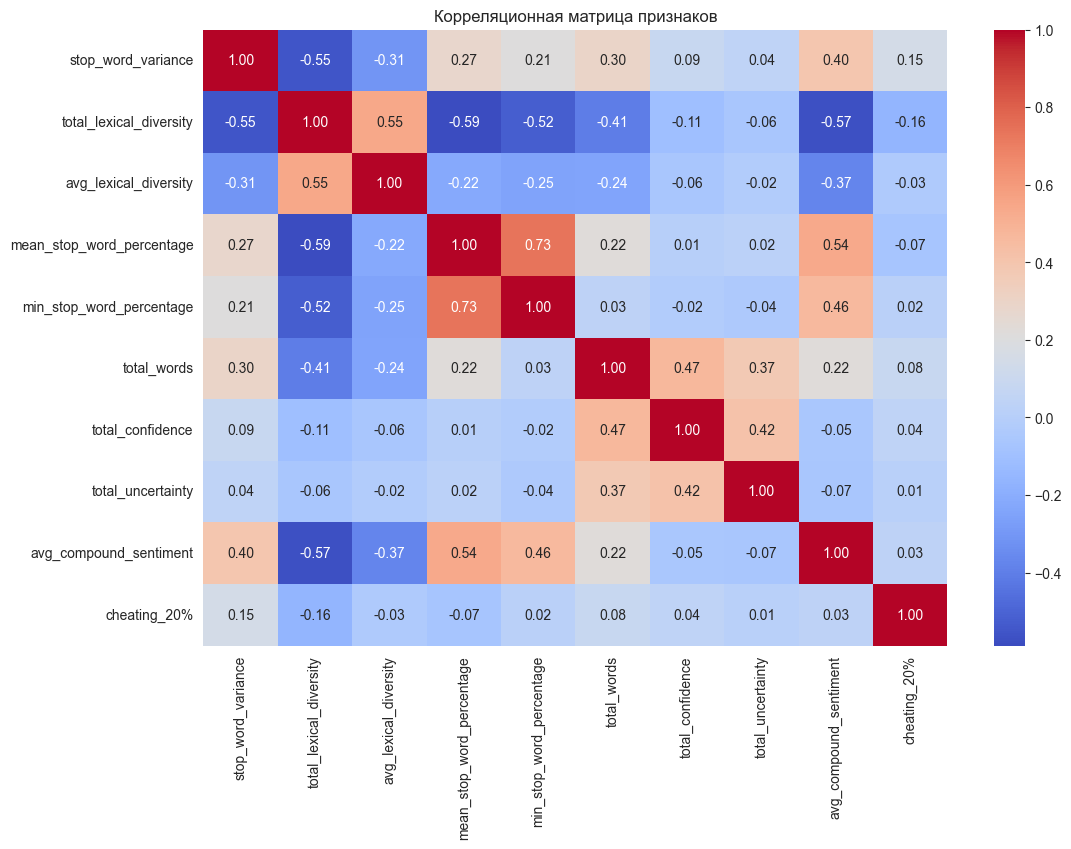

In [78]:
# Итоговый список признаков
final_features = [
    'stop_word_variance',  
    'total_lexical_diversity', # avg_lexical_diversity заменило, не добавил в модели 
    'avg_lexical_diversity', 
    'mean_stop_word_percentage',  
    'min_stop_word_percentage',
    'total_words',
    'total_confidence', # Не добавил в итоговую модель, так как создавали скорее шум
    'total_uncertainty', # Не добавил в итоговую модель, так как создавали скорее шум
    'avg_compound_sentiment',
    'cheating_20%'  # Для анализа с целевой переменной
]

numeric_features = df[final_features]
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Корреляционная матрица признаков")
plt.show()


Мультиколлинеарность  

In [99]:
# Подготовка данных
X = df[final_features].drop(columns=['cheating_20%'])  # минус целевая
X = add_constant(X)  # Добавляем константу для вычисления VIF

# Расчет VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                     Feature        VIF
0                      const  78.575390
1         stop_word_variance   1.502740
2    total_lexical_diversity   2.983953
3      avg_lexical_diversity   1.497545
4  mean_stop_word_percentage   2.761028
5   min_stop_word_percentage   2.463415
6                total_words   1.782726
7           total_confidence   1.449631
8          total_uncertainty   1.294546
9     avg_compound_sentiment   1.764233


### Проверка на выбросы

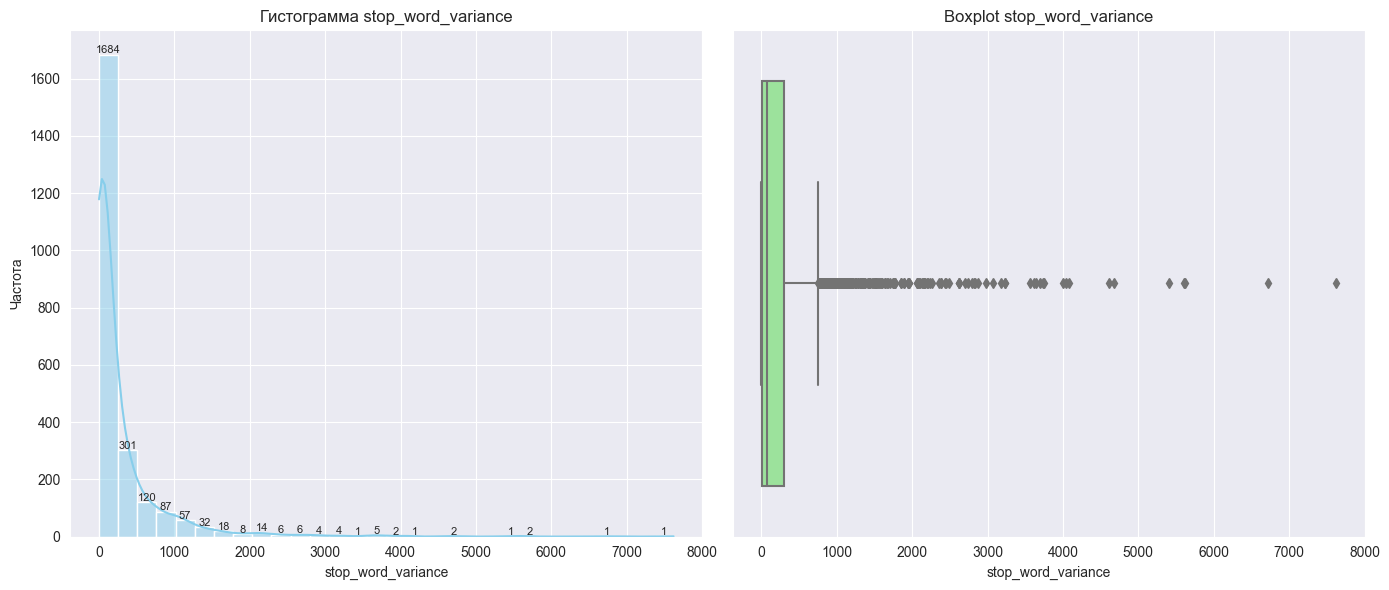

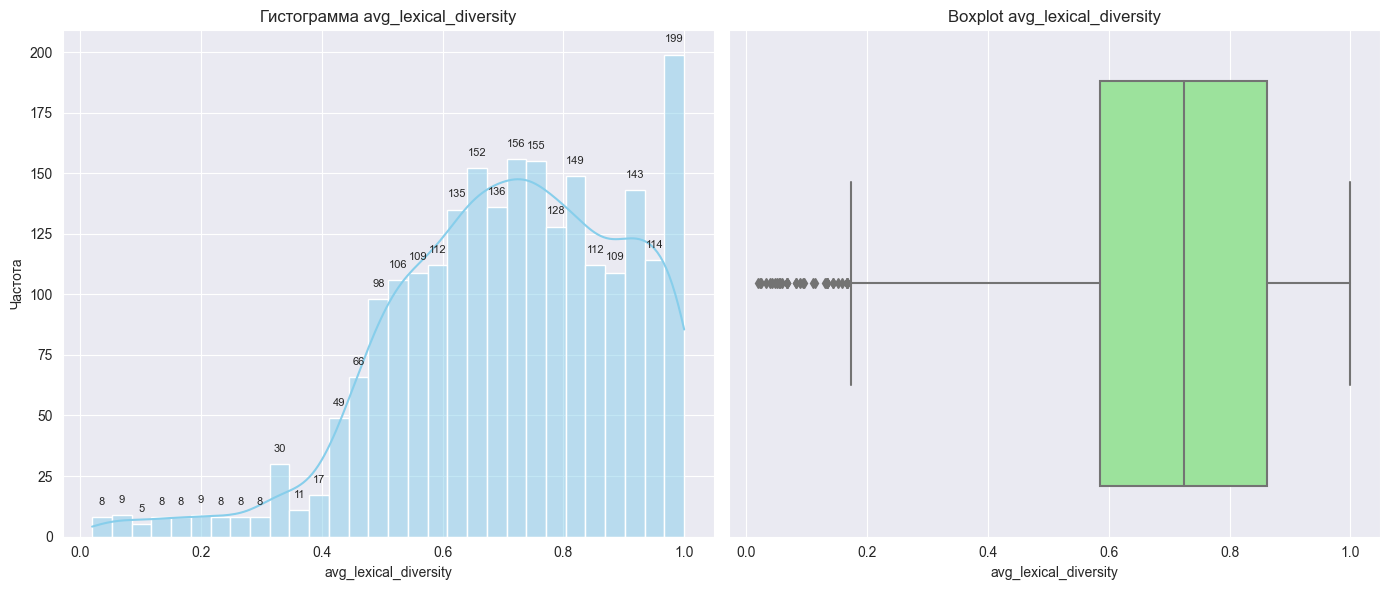

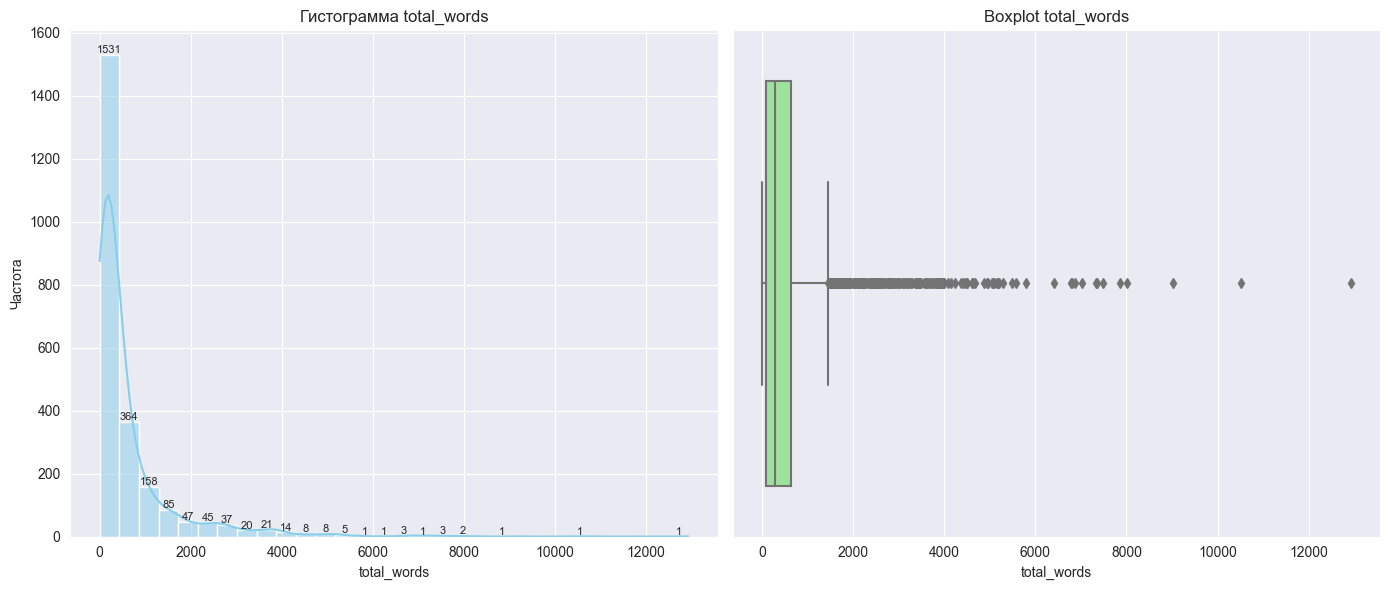

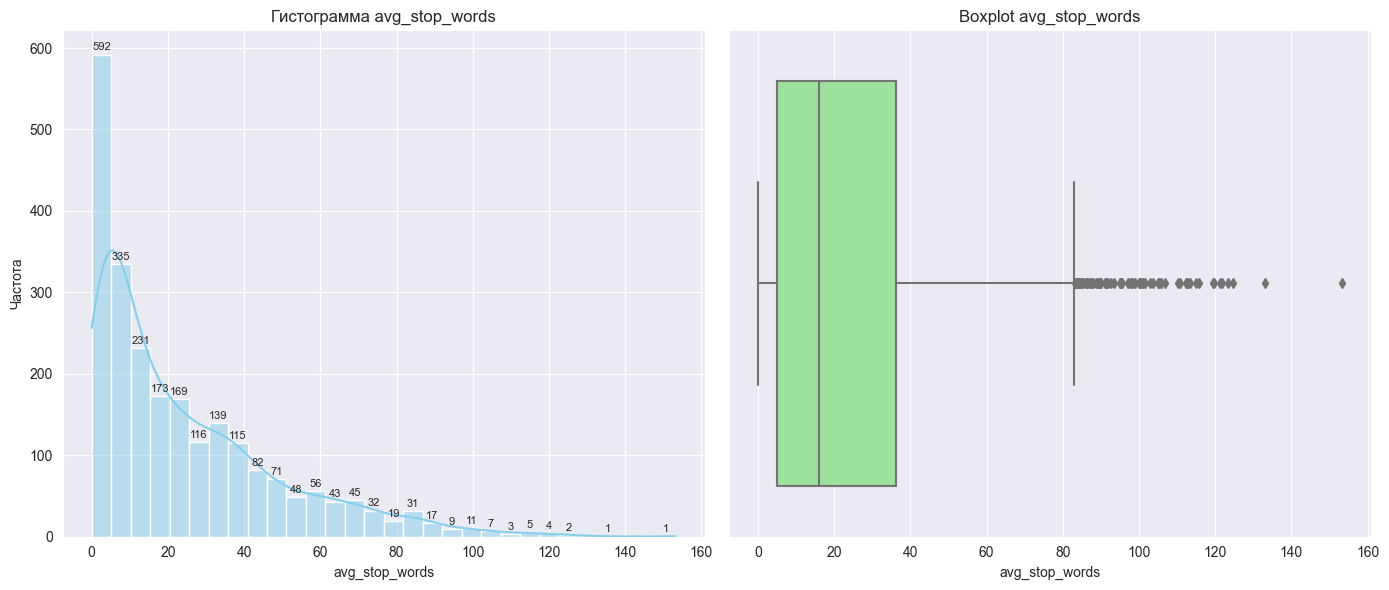

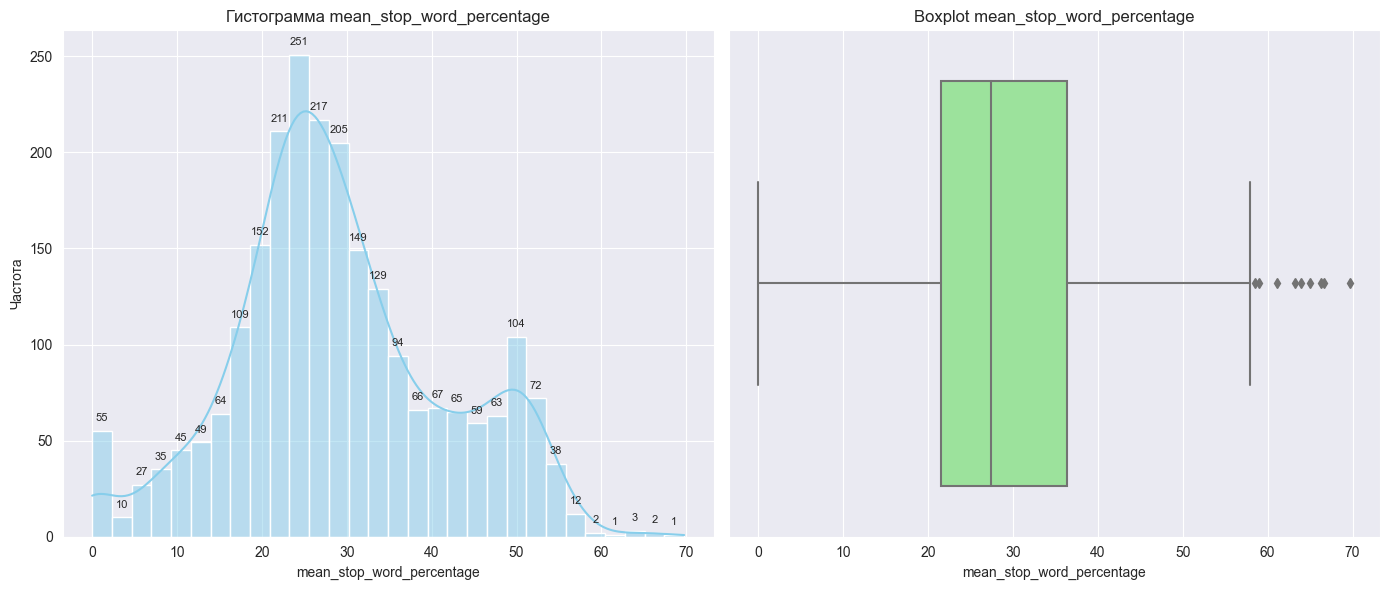

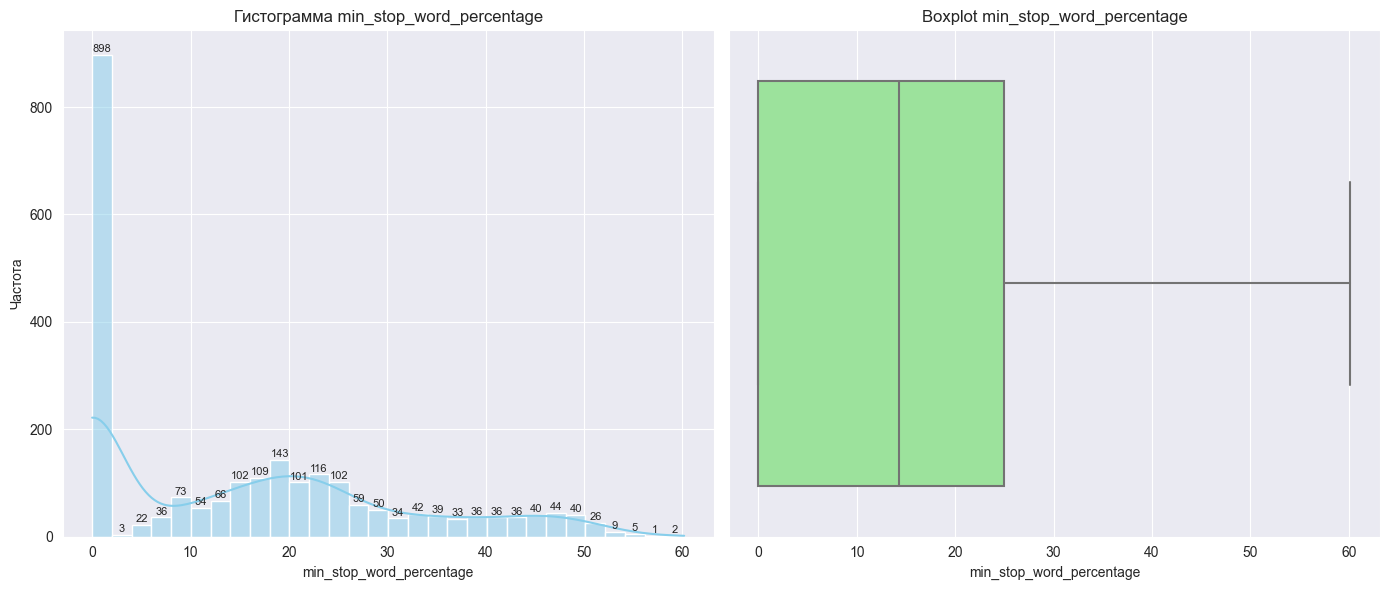

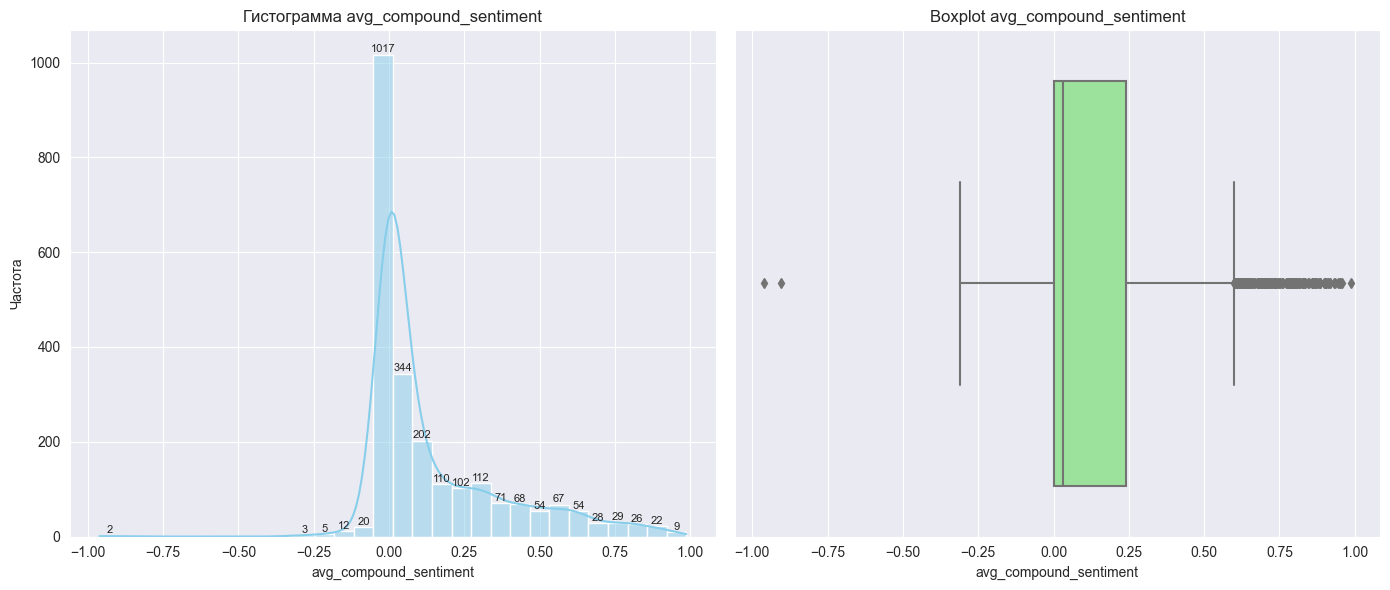

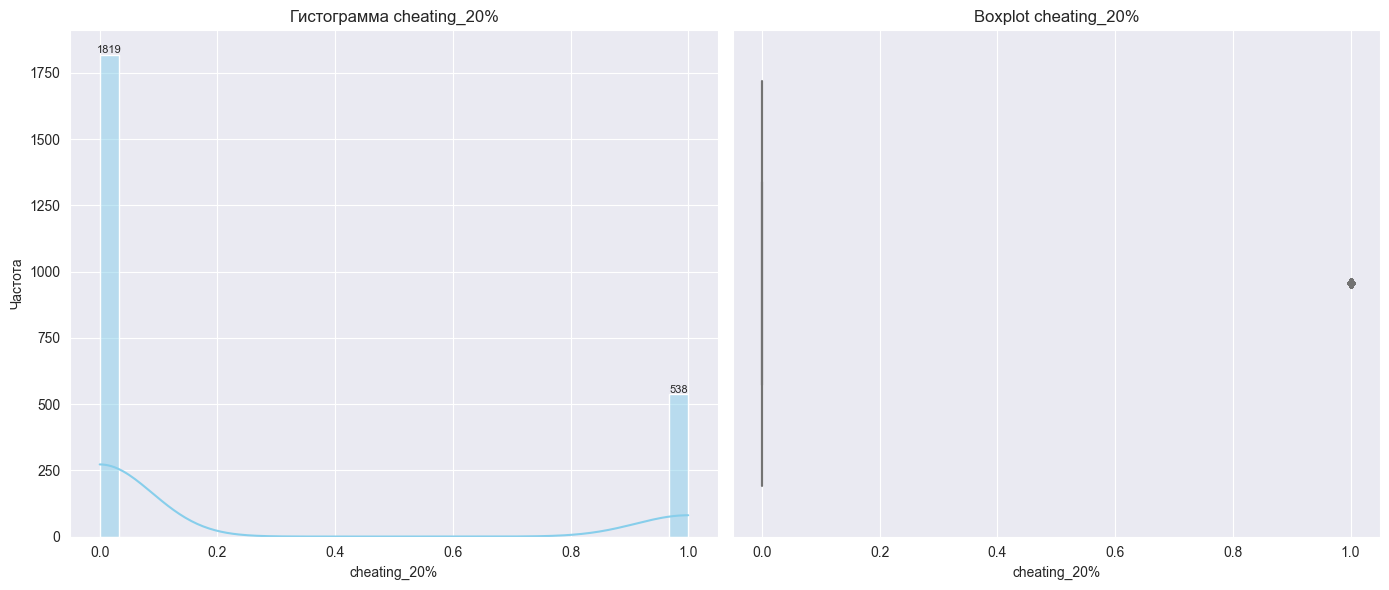

In [74]:
#  Признаки для проверки на выбросы
features = ['stop_word_variance', 'avg_lexical_diversity','total_words',
            'avg_stop_words','mean_stop_word_percentage','min_stop_word_percentage',
            'avg_compound_sentiment', 'cheating_20%']

# Проверка выбросов
for feature in features:
    plt.figure(figsize=(14, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    hist_data = sns.histplot(df[feature], kde=True, bins=30, color="skyblue")
    plt.title(f'Гистограмма {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')

    # Добавление меток частот на гистограмму
    for patch in hist_data.patches:
        bin_center = patch.get_x() + patch.get_width() / 2
        height = patch.get_height()
        if height > 0:
            plt.text(bin_center, height + 5, str(int(height)), ha='center', fontsize=8)

    # Boxplot для выявления выбросов
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature], color="lightgreen")
    plt.title(f'Boxplot {feature}')
    plt.xlabel(feature)

    # Показ графиков
    plt.tight_layout()
    plt.show()


## Модели

### Модель 1, Recall немного поднят, но precision сохранен - все еще добряк, вероятно даст лучший результат

In [100]:
# Признаки и целевая переменная
features = ['stop_word_variance', 'avg_lexical_diversity',
            'total_words', 'mean_stop_word_percentage', 'min_stop_word_percentage',
            'avg_compound_sentiment']
X = df[features]
y = df['cheating_20%']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

param_dist = {
    'iterations': randint(300, 600),
    'learning_rate': uniform(0.01, 0.05),
    'depth': randint(6, 10),
    'class_weights': [{0: 1, 1: 10}, {0: 1, 1: 12}, {0: 1, 1: 15}],
    'subsample': uniform(0.5, 0.3),
    'colsample_bylevel': uniform(0.5, 0.3)
}

# Инициализация модели
catboost_model = CatBoostClassifier(
    eval_metric='Precision',
    random_seed=42,
    verbose=100
)

# RandomizedSearchCV для подбора гиперпараметров
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='precision',
    n_jobs=-1,
    random_state=42
)

# Подбор гиперпараметров
random_search.fit(X_train, y_train)

# Лучшая модель
best_model = random_search.best_estimator_

# Прогноз вероятностей
y_proba = best_model.predict_proba(X_test)[:, 1]

# Поиск оптимального порога для максимизации Precision
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Условие: максимизация Precision при Recall >= 0.30
optimal_threshold_index = np.argmax([
    p if r >= 0.30 else 0 for p, r in zip(precision, recall)
])
optimal_threshold = thresholds[optimal_threshold_index]

# Применение оптимального порога
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# Вывод оптимального порога
print("=" * 50)
print(f"Оптимальный порог для классификации: {optimal_threshold:.4f}")
print("=" * 50)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
conf_table = PrettyTable()
conf_table.field_names = ["", "Predicted 0 (Модель сказала 'нечитинг')", "Predicted 1 (Модель сказала 'читинг')"]
conf_table.add_row(["Actual 0 (На самом деле 'нечитинг')", conf_matrix[0, 0], conf_matrix[0, 1]])
conf_table.add_row(["Actual 1 (На самом деле 'читинг')", conf_matrix[1, 0], conf_matrix[1, 1]])
print("\nConfusion Matrix (Матрица ошибок):")
print(conf_table)

# Classification Report
classification = classification_report(y_test, y_pred_adjusted, output_dict=True)
classification_table = PrettyTable()
classification_table.field_names = ["Metric", "Class 0", "Class 1", "Accuracy", "Macro Avg", "Weighted Avg"]
classification_table.add_row([
    "Precision",
    f"{classification['0']['precision']:.2f}",
    f"{classification['1']['precision']:.2f}",
    "-",
    f"{classification['macro avg']['precision']:.2f}",
    f"{classification['weighted avg']['precision']:.2f}"
])
classification_table.add_row([
    "Recall",
    f"{classification['0']['recall']:.2f}",
    f"{classification['1']['recall']:.2f}",
    f"{classification['accuracy']:.2f}",
    f"{classification['macro avg']['recall']:.2f}",
    f"{classification['weighted avg']['recall']:.2f}"
])
classification_table.add_row([
    "F1-Score",
    f"{classification['0']['f1-score']:.2f}",
    f"{classification['1']['f1-score']:.2f}",
    "-",
    f"{classification['macro avg']['f1-score']:.2f}",
    f"{classification['weighted avg']['f1-score']:.2f}"
])
print("\nClassification Report:")
print(classification_table)

print("\nИтоговые метрики:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Важность признаков
feature_importances = best_model.get_feature_importance()
feature_table = PrettyTable()
feature_table.field_names = ["Feature", "Importance"]
for feature, importance in zip(features, feature_importances):
    feature_table.add_row([feature, f"{importance:.2f}"])
print("\nFeature Importances:")
print(feature_table)


0:	learn: 0.7737628	total: 7.14ms	remaining: 3.66s
100:	learn: 0.8596416	total: 1.01s	remaining: 4.12s
200:	learn: 0.9184139	total: 1.68s	remaining: 2.61s
300:	learn: 0.9457874	total: 2.37s	remaining: 1.67s
400:	learn: 0.9657321	total: 3.1s	remaining: 866ms
500:	learn: 0.9772066	total: 3.87s	remaining: 92.7ms
512:	learn: 0.9783928	total: 3.96s	remaining: 0us
Оптимальный порог для классификации: 0.7701

Confusion Matrix (Матрица ошибок):
+-------------------------------------+-----------------------------------------+---------------------------------------+
|                                     | Predicted 0 (Модель сказала 'нечитинг') | Predicted 1 (Модель сказала 'читинг') |
+-------------------------------------+-----------------------------------------+---------------------------------------+
| Actual 0 (На самом деле 'нечитинг') |                   421                   |                   34                  |
|  Actual 1 (На самом деле 'читинг')  |                    90          

### Модель 2 - добряк, помечает читингом, если уверена на 99%

In [96]:
features = ['stop_word_variance', 'avg_lexical_diversity',
            'total_words', 'mean_stop_word_percentage', 'min_stop_word_percentage',
            'avg_compound_sentiment']

# Разделение данных
X = df[features]
y = df['cheating_20%']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Настройка гиперпараметров модели
param_dist = {
    'iterations': randint(300, 600),
    'learning_rate': uniform(0.01, 0.05),
    'depth': randint(6, 9),
    'class_weights': [{0: 1, 1: 5}, {0: 1, 1: 6}, {0: 1, 1: 7}],
    'subsample': uniform(0.7, 0.3),
    'colsample_bylevel': uniform(0.7, 0.3),
}

# Инициализация модели
catboost_model = CatBoostClassifier(
    eval_metric='Precision',
    random_seed=42,
    verbose=100
)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='precision',
    n_jobs=-1,
    random_state=42
)

# Обучение RandomizedSearchCV
random_search.fit(X_train, y_train)

# Результаты оптимизации
print("=" * 50)
print("Лучшие параметры:")
print(random_search.best_params_)
print("=" * 50)

# Финальная модель
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Прогнозы
y_proba = best_model.predict_proba(X_test)[:, 1]

# Оптимизация порога для максимизации Precision
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Учитываем, что thresholds на 1 меньше, чем precision и recall
optimal_threshold = thresholds[np.argmax(precision[:-1])]
print(f"Оптимальный порог для максимизации Precision: {optimal_threshold}")

# Применение оптимального порога
y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)

# Метрики
accuracy = accuracy_score(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
report = classification_report(y_test, y_pred_adjusted, output_dict=True)

print("=" * 50)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print("=" * 50)

# Таблица Classification Report
classification_table = tabulate(
    [
        ["Precision", report["0"]["precision"], report["1"]["precision"]],
        ["Recall", report["0"]["recall"], report["1"]["recall"]],
        ["F1-Score", report["0"]["f1-score"], report["1"]["f1-score"]],
        ["Support", report["0"]["support"], report["1"]["support"]],
    ],
    headers=["Metric", "Class 0", "Class 1"],
    tablefmt="pretty",
)
print("\nClassification Report:")
print(classification_table)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
conf_matrix_table = tabulate(
    conf_matrix,
    headers=["Predicted 0", "Predicted 1"],
    showindex=["Actual 0", "Actual 1"],
    tablefmt="pretty",
)
print("\nConfusion Matrix:")
print(conf_matrix_table)

# Анализ важности признаков
feature_importances = best_model.get_feature_importance()
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(tabulate(importances_df, headers='keys', tablefmt='pretty'))


0:	learn: 0.6854345	total: 4.2ms	remaining: 2.34s
100:	learn: 0.8144506	total: 368ms	remaining: 1.66s
200:	learn: 0.8714597	total: 738ms	remaining: 1.31s
300:	learn: 0.9146618	total: 1.11s	remaining: 947ms
400:	learn: 0.9468985	total: 1.47s	remaining: 576ms
500:	learn: 0.9664269	total: 1.86s	remaining: 212ms
557:	learn: 0.9724903	total: 2.06s	remaining: 0us
Лучшие параметры:
{'class_weights': {0: 1, 1: 5}, 'colsample_bylevel': 0.7452152631896288, 'depth': 8, 'iterations': 558, 'learning_rate': 0.03954464715941209, 'subsample': 0.9032693085526846}
0:	learn: 0.6854345	test: 0.6607370	best: 0.6607370 (0)	total: 4.29ms	remaining: 2.39s
100:	learn: 0.8144506	test: 0.7331137	best: 0.7404459 (91)	total: 369ms	remaining: 1.67s
200:	learn: 0.8714597	test: 0.7504690	best: 0.7586837 (193)	total: 765ms	remaining: 1.36s
300:	learn: 0.9146618	test: 0.7644628	best: 0.7669903 (221)	total: 1.13s	remaining: 965ms
400:	learn: 0.9468985	test: 0.7772622	best: 0.7840909 (393)	total: 1.52s	remaining: 595ms
5

### Модель 3. Повышенный Recall. Экспериментальная версия

0:	learn: 0.5065177	total: 2.83ms	remaining: 883ms
100:	learn: 0.7360533	total: 289ms	remaining: 607ms
200:	learn: 0.8440222	total: 553ms	remaining: 308ms
300:	learn: 0.9016266	total: 804ms	remaining: 32ms
312:	learn: 0.9045964	total: 844ms	remaining: 0us
Лучшие параметры: {'class_weights': {0: 2, 1: 1}, 'colsample_bylevel': 0.9188818535014192, 'depth': 7, 'iterations': 313, 'learning_rate': 0.05436063712881633, 'subsample': 0.8416644775485848}
0:	learn: 0.5065177	test: 0.2529644	best: 0.2529644 (0)	total: 2.31ms	remaining: 722ms
100:	learn: 0.7360533	test: 0.3161765	best: 0.3543307 (35)	total: 249ms	remaining: 522ms
200:	learn: 0.8440222	test: 0.3176895	best: 0.3543307 (35)	total: 504ms	remaining: 281ms
300:	learn: 0.9016266	test: 0.3450704	best: 0.3543307 (35)	total: 779ms	remaining: 31.1ms
312:	learn: 0.9045964	test: 0.3402778	best: 0.3543307 (35)	total: 811ms	remaining: 0us

bestTest = 0.3543307087
bestIteration = 35

Shrink model to first 36 iterations.
Оптимальный порог: 0.316279

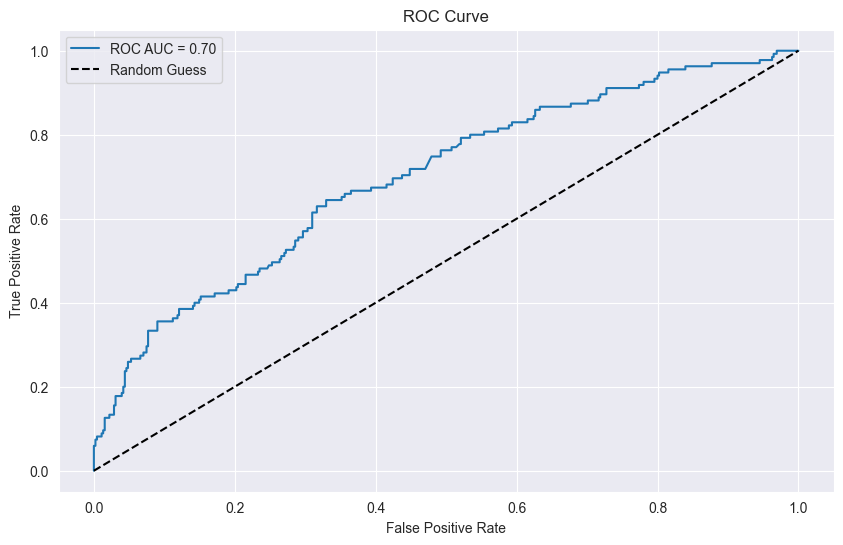

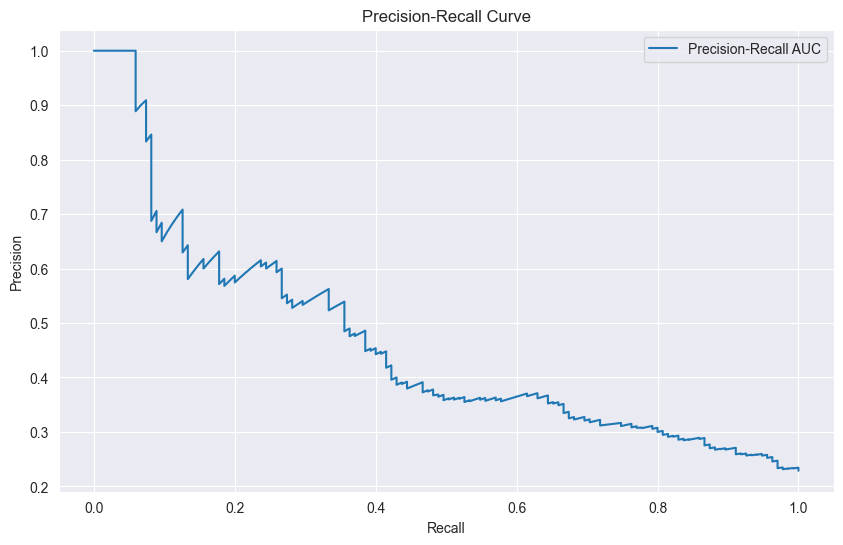

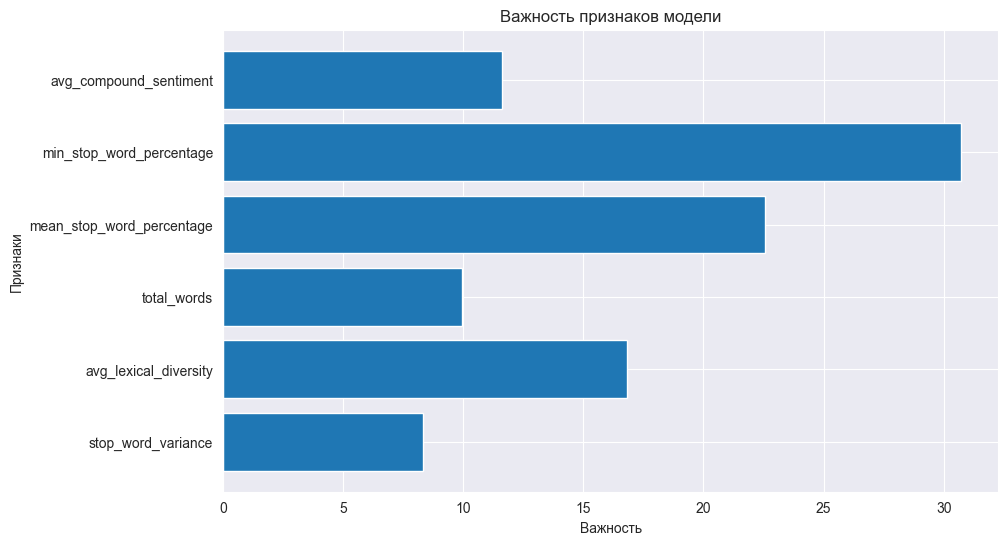

In [90]:
features = ['stop_word_variance', 'avg_lexical_diversity',
            'total_words', 'mean_stop_word_percentage', 'min_stop_word_percentage',
            'avg_compound_sentiment']

X = df[features]
y = df['cheating_20%']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Балансировка данных с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Настройка гиперпараметров
param_dist = {
    'iterations': randint(100, 500),
    'learning_rate': uniform(0.01, 0.05),
    'depth': randint(4, 8),
    'class_weights': [{0: w, 1: 1} for w in range(2, 5)],
    'subsample': uniform(0.7, 0.3),
    'colsample_bylevel': uniform(0.7, 0.3),
}

# Инициализация модели
catboost_model = CatBoostClassifier(eval_metric='F1', random_seed=42, verbose=100)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42
)

# Обучение RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Лучшая модель
best_model = random_search.best_estimator_
print("Лучшие параметры:", random_search.best_params_)

# Финальная модель
best_model.fit(X_train_resampled, y_train_resampled, eval_set=(X_test, y_test), use_best_model=True)

# Прогноз вероятностей
y_proba = best_model.predict_proba(X_test)[:, 1]

# Оптимальный порог
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
weighted_scores = (2 * precision * recall) / (precision + recall + 1e-10)
optimal_index = np.argmax(weighted_scores)
chosen_threshold = thresholds[optimal_index]
print(f"Оптимальный порог: {chosen_threshold}")
y_pred_adjusted = (y_proba >= chosen_threshold).astype(int)

# Итоговые метрики
print("\nИтоговые метрики:")
print(tabulate([['Precision', classification_report(y_test, y_pred_adjusted, output_dict=True)['1']['precision']],
                ['Recall', classification_report(y_test, y_pred_adjusted, output_dict=True)['1']['recall']],
                ['F1-Score', classification_report(y_test, y_pred_adjusted, output_dict=True)['1']['f1-score']],
                ['Accuracy', accuracy_score(y_test, y_pred_adjusted)],
                ['ROC-AUC', roc_auc_score(y_test, y_proba)]],
               headers=['Метрика', 'Значение'], tablefmt='fancy_grid'))

# Confusion Matrix
conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred_adjusted),
    index=['Actual 0 (На самом деле "нечитинг")', 'Actual 1 (На самом деле "читинг")'],
    columns=['Predicted 0 (Модель сказала "нечитинг")', 'Predicted 1 (Модель сказала "читинг")']
)
print("\nConfusion Matrix (Матрица ошибок):")
print(tabulate(conf_matrix, headers='keys', tablefmt='fancy_grid'))

# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Визуализация Precision-Recall кривой
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'Precision-Recall AUC')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(features, best_model.get_feature_importance())
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков модели')
plt.show()
